# Fixing oscillations

In [1]:
import tensorflow as tf
import numpy as np
import argparse
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
# import cProfile
import copy as cp
from sklearn.model_selection import KFold

## Import IRM libraries

In [2]:
from data_construct import * ## contains functions for constructing data 
from IRM_methods import *    ## contains IRM games methods 

# MNIST digits:  2 environments

Below we illustrate how to use our IRM methods. 
We first setup the data in the cell below.  We set p_color_list = [0.2, 0.1] 
(from experiments in Arjovsky et.al.); note that there is marginal difference between the probabilities of 
switching the labels in the two environments. This marginal difference is useful for IRM methods to learn 
invariant predictors across environments that exploit the shape of digits and not the color. 

In [4]:
# Create data for each environment

n_e = 2  # number of environments

p_color_list = [0.2, 0.1] # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25]*n_e # list of probabilities of switching pre-label
D = assemble_data_mnist() # initialize mnist digits data object

D.create_training_data(n_e, p_color_list, p_label_list) # creates the training environments

p_label_test = 0.25 # probability of switching pre-label in test environment
p_color_test = 0.9  # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_e)  # sets up the testing environment
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

### Initialize the architecture for F-IRM game 

In the cell below, for each environment we initialize an architecture. We use the MLP architectue that was described in https://arxiv.org/pdf/2002.04692.pdf . 

If you decide to choose a new architecture, please take care to ensure that you keep the input shape as is that is length, width, and height (which we obtained above) and output shape as num_classes.

In [6]:
# we use same architecture across environments and store it in a list
model_list = [] 
for e in range(n_e):
    model_list.append(keras.Sequential([
            keras.layers.Flatten(input_shape=(length, width,height)),
            keras.layers.Dense(390, activation = 'elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
    ]))

### Select other hyper-parameters for the F-IRM game


In [7]:
num_epochs       = 25
batch_size       = 256
termination_acc  = 0.6
warm_start       = 100
learning_rate    = 2.5e-4

### Initialize F-IRM model, fit and evaluate

In [8]:
# initialize F-IRM model (we pass the hyper-parameters that we chose above)
F_game = fixed_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
F_game.fit(D.data_tuple_list)

# evaluate function runs and evaluates train and test accuracy of the final model
F_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print ("Training accuracy " + str(F_game.train_acc)) 
print ("Testing accuracy " + str(F_game.test_acc))

Epoch: 0
Epoch: 1
Epoch: 2
Training accuracy 0.5668666958808899
Testing accuracy 0.6050000190734863


### Selecting termination_acc using training accuracy plot

1. Start by setting a very low termination accuracy value say 0.1 and large number of epochs. 
2. Plot the training accuracy plot to see the range of oscillations; use the minimum value around which oscillation occurs as the threshold 

3. In the above experiment, we found 0.6 to be the value based on the plot. 

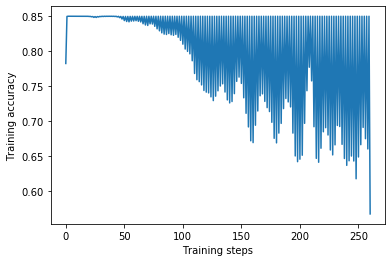

In [10]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(F_game.train_accuracy_results)